In [289]:
import numpy as np
from scipy.optimize import minimize
import casadi.casadi as cs
import matplotlib.pyplot as plt

## Unconstrained optimisation

Suppose we need to solve the optimisation problem
$$\operatorname*{Minimize}_{x\in{\rm I\!R}}x(x-1)e^x.$$
The cost function is $f(x) = x(x-1)e^x$. In other words, we need to find a point $x^\star$ such that $f(x) \geq f(x^\star)$ for all $x\in{\rm I\!R}$; such point is called a minimiser of $f$. We also need to determine the minimum value of $f$, that is $f^\star = f(x^\star).$

Let us first see how the graph of the function looks like...

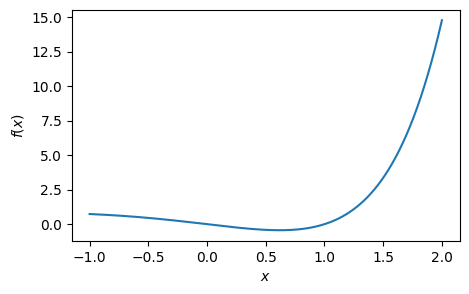

In [290]:
xs = np.linspace(-1, 2, 200)
ys = xs*((xs - 1)*np.exp(xs))

plt.figure(figsize=(5, 3))
plt.plot(xs, ys)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

we see that the minimiser of $f$ is at around $x^\star \approx 0.7$ (roughly).

Let us now solve the optimisation problem numerically using `scipy`.

In [310]:
# 1. We define the cost function using CasADi
def f(x):
    return x*(x-1)*np.exp(x)

# 2. We construct the derivative of f using CasADi
x_ = cs.SX.sym('x')
df_ = cs.gradient(f(x_), x_)
df_fun = cs.Function('df', [x_], [df_])
df = lambda x: float(df_fun(x))

# 3. We solve the problem (we need to provide an initial guess, x0)
x_guess = 0.7
res = minimize(f, x_guess, method='SLSQP', jac=df)

# 4. Print the solution
if res.success:
    print(f"Function f has a minimiser at x* ≈ {res.x[0]:.5f}")
    print(f"The derivative at the optimiser is f'(x*) ≈ {res.jac[0]:.5f}")

Function f has a minimiser at x* ≈ 0.61811
The derivative at the optimiser is f'(x*) ≈ 0.00031


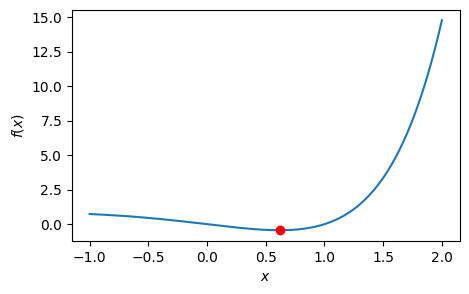

In [293]:
plt.figure(figsize=(5, 3))
plt.plot(xs, f(xs))
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(res.x, res.fun, 'ro') # minimiser + minimum value
plt.show()

## Example with vector decision variable

We want to determine a minimiser of the Rosenbrock function, $r:{\rm I\!R}^n \to {\rm I\!R}^n $, which is given by
$$r(x) = \sum_{i} 100(x_{i+1}-x_{i}^2)^2 + (1-x_i)^2.$$
Let us first plot the function in the case $n=2$...

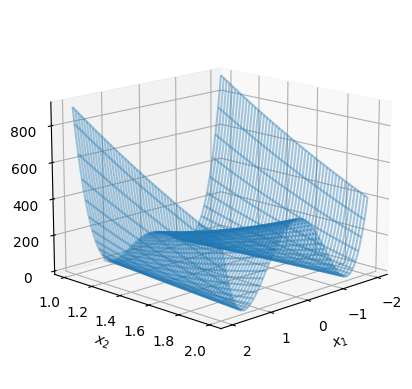

In [294]:
X = np.linspace(-2, 2, 100)
Y = np.linspace(1, 2, 50)
[X, Y] = np.meshgrid(X, Y)
f = lambda x,y: 100*(y-x**2)**2 + (x-1)**2
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_wireframe(X, Y, f(X, Y), alpha=0.4)
ax.view_init(azim=45, elev=15)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

We want to solve the problem
$$\operatorname*{Minimize}_{x\in{\rm I\!R}^2}r(x)$$
In fact, we want to determine a *local* minimiser of $r$.

In [311]:
# 1. We define the cost function using CasADi
def rosen(x):
    return cs.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

# 2. We construct the gradient of the Rosenbrock function using CasADi
x_ = cs.SX.sym('x', 2)
rosen_ = rosen(x_)
d_rosen_ = cs.gradient(rosen_, x_)
d_rosen_fun = cs.Function('d_rosen', [x_], [d_rosen_])
d_rosen_lam = lambda x: np.array(d_rosen_fun(x)).flatten()

# 3. Solve the problem
x_guess = [0, 0]
res = minimize(rosen, x_guess, method='SLSQP', jac=d_rosen_lam)

# 4. Print the result
if res.success:
    print(f"A (local) minimiser was found at x* = {res.x}")
    print(f"The optimal cost is f(x*) = {res.fun:.2e}")
    print(f"The gradient of the cost function at the solution is {res.jac}")

A (local) minimiser was found at x* = [0.99983786 0.9996758 ]
The optimal cost is f(x*) = 2.63e-08
The gradient of the cost function at the solution is [-3.49172259e-04  1.24450712e-05]


## Constrained optimisation

We often need to minimise a cost function while imposing certain constraints on the decision variable. The constraints can be (i) *equality constraints* of the form $c(c) = 0$, or (ii) *inequality constraints* of the form $h(x)\leq 0$.

Let us give an example with equality constraints:
$$\begin{align*}
\operatorname*{Minimise}_{x\in{\rm I\!R}^n}\;& r(x),
\\
\text{subject to:}\;&x^\intercal x = 2,
\end{align*}$$
where $r$ is the Rosenbrock function.

Let us solve this problem for $n=5$.



In [324]:
# 1A. We define the cost function using CasADi
def rosen(x):
    return cs.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

# 1B. We construct the gradient of the cost function using CasADi
nx = 5
x_ = cs.SX.sym('x', nx)
rosen_ = rosen(x_)
d_rosen_ = cs.gradient(rosen_, x_)
d_rosen_fun = cs.Function('d_rosen', [x_], [d_rosen_])
d_rosen_lam = lambda x: np.array(d_rosen_fun(x)).flatten()

# 2A. Define the constraints function c(x) = x'x - 2 using CasADi
def c(x):
    return cs.sumsqr(x) - 2.0

# 2B. Compute the gradient of c(x) using CasADi
dc_ = cs.jacobian(c(x_), x_)
dc_fun = cs.Function('dc', [x_], [dc_])

c_lam = lambda x: float(c(x))
dc_lam = lambda x: np.array(dc_fun(x)).flatten()

# 3. Define the constraints
constraints = [
    {'type': 'eq', 'fun': c_lam, 'jac': dc_lam},
    # more constraints go here
]

# 4. Solve the problem
x0 = np.array([1.3, 0.7, 0.8, 0.9, 1.0])
res = minimize(rosen, x0, method='SLSQP', jac=d_rosen_lam, constraints=constraints,)


# 5. Print the result
if res.success:
    print(f"A (local) minimiser was found at x* = {res.x}")
    print(f"The optimal cost is f(x*) = {res.fun:.2e}")
    print(f"The constraints function at the solution is  c(x*) ≈ {c_lam(res.x):.2e}")
    print(f"The gradient of the cost function at the solution is {res.jac}")

A (local) minimiser was found at x* = [0.88856163 0.79199756 0.63053389 0.40032002 0.15927687]
The optimal cost is f(x*) = 5.54e-01
The constraints function at the solution is  c(x*) ≈ 1.35e-07
The gradient of the cost function at the solution is [-1.09572157 -0.96197382 -0.77701912 -0.49314729 -0.19585031]


## Global optimisation

